In [6]:
# import yfinance as yf
# import pandas as pd

# # 티커와 그에 해당하는 이름을 정의합니다.
# # 사용자는 이 딕셔너리에 새로운 티커와 이름을 추가할 수 있습니다.
# tickers = {
#     "CL=F": "WTI",
#     "USDKRW=X": "USDKRW",
#     "^KS11": "KOSPI200",
#     "^VIX": "VIX"
# }

# data = pd.DataFrame()  # 빈 DataFrame을 초기화합니다.

# # 각 티커에 대한 데이터를 다운로드하고 단일 DataFrame으로 병합합니다.
# for ticker, name in tickers.items():
#     series = yf.download(ticker, start="2006-12-30", end="2023-09-21")['Close']  # 각 티커에 대한 종가 데이터를 다운로드합니다.
#     series.name = name  # 다운로드한 시리즈의 이름을 설정합니다.
#     if data.empty:  # 첫 번째 티커의 경우, data DataFrame을 초기화합니다.
#         data = pd.DataFrame(series).reset_index()
#     else:  # 그 이후의 티커에 대해서는 data DataFrame과 병합합니다.
#         data = pd.merge(data, pd.DataFrame(series).reset_index(), on='Date', how='outer')

# # 'Date' 컬럼의 이름을 변경하고 인덱스로 설정합니다.
# data.rename(columns={'Date': 'Date'}, inplace=True)
# data.set_index('Date', inplace=True)

# # 누락된 데이터를 처리합니다.
# data.fillna(method='ffill', inplace=True)  # 누락된 데이터를 앞쪽으로 채웁니다.
# data.fillna(method='bfill', inplace=True)  # 시작 부분의 누락된 데이터를 뒤쪽으로 채웁니다.

# # KOSPI 200에 대한 포워드 스테이지를 계산합니다.
# forward_days = 60
# data['Forward_Return'] = data['KOSPI200'].shift(-forward_days) / data['KOSPI200'] - 1  # 포워드 리턴을 계산합니다.
# data['forward_stage'] = pd.cut(data['Forward_Return'], bins=[-float('inf'), 0, 0.04, float('inf')], labels=['down', 'neutral', 'up'])  # 포워드 리턴을 기반으로 스테이지를 분류합니다.

# # 'forward_stage'에서 NaN이 있는 행을 삭제합니다.
# data.dropna(subset=['forward_stage'], inplace=True)

# # 숫자형 컬럼을 2소수점 자리로 반올림합니다.
# numerical_columns = [name for name in tickers.values() if name != 'KOSPI200']  # 'KOSPI200'을 제외한 모든 컬럼을 선택합니다.
# data[numerical_columns] = data[numerical_columns].round(2)  # 선택한 컬럼을 반올림합니다.

# # 인덱스를 재설정하고 'Date' 컬럼을 형식화합니다.
# data.reset_index(inplace=True)
# data['Date'] = data['Date'].dt.strftime('%y-%m-%d')

# # 'Forward_Return' 컬럼을 삭제하고 컬럼 순서를 재배열합니다.
# data = data[['Date', 'forward_stage'] + numerical_columns]

# # 필요한 경우 CSV로 저장합니다.
# data.to_csv('daily_data_value.csv', index=False)

# # DataFrame의 처음 몇 행을 출력합니다.
# print(data.head())


In [7]:
# -*- coding: utf-8 -*- 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn.metrics as mt 
from sklearn.tree import export_graphviz 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV 
import joblib 
from sklearn.metrics import confusion_matrix 

# 1. Load the modified CSV data
model_data = pd.read_csv("correct_datasets.csv", encoding='cp949')

# Set 'Date' column as index
model_data.set_index('Date', inplace=True)

# 2. Generate complete data of features and label
X = model_data.drop(columns=['forward_stage'])  # Exclude the 'forward_stage' column for features
y = model_data['forward_stage']  # Use 'forward_stage' column as label

X_past = X[y.notna()] 
y_past = y[y.notna()]

# 3. Split the data into train and test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X_past, y_past):
    X_train, X_test = X_past.iloc[train_index,], X_past.iloc[test_index,] 
    y_train, y_test = y_past.iloc[train_index], y_past.iloc[test_index]

# 4. Model fine-tuning: find optimal hyperparameters
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=1, random_state=42)  # n_jobs를 1로 설정

param_dist_rf = {
    'n_estimators': [50, 100], # 500 제외
    'max_leaf_nodes': [20, 30, 40, 50], # 40, 50 제외
    'max_features': [1, 2, 3],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rnd_search = RandomizedSearchCV(rnd_clf, param_dist_rf, cv=10, random_state=42)
rnd_search.fit(X_train, y_train)
print(rnd_search.best_params_)

# 5. Train the model and evaluate it using K-fold cross-validation
rnd_search = RandomizedSearchCV(rnd_clf, param_dist_rf, cv=10, random_state=42, n_jobs=-1)  # n_jobs를 1로 설정
rnd_scores = cross_val_score(rnd_clf, X_train, y_train, scoring="accuracy", cv=10)
print("\n<10-fold cross-validation>")
print("accuracy score mean: ", rnd_scores.mean())

# 6. Train the final model
rnd_clf.fit(X_train, y_train)
print("\n<AI model: machine learning done >")
print("accuracy_score of train data(0.8 of sample): ", rnd_clf.score(X_train, y_train))

# 7. Evaluate the model on test data
print("accuracy_score of test data(0.2 of sample): ", rnd_clf.score(X_test, y_test))

# 8. Check the confusion matrix
y_test_pred = rnd_clf.predict(X_test) 
cm1 = confusion_matrix(y_test, y_test_pred, labels=["up", "neutral", "down"]) 
print("\n<Confusion matrix>")
print("(of test)")
print("up", "neutral", "down")
print(cm1)
cm2 = confusion_matrix(y_past, rnd_clf.predict(X_past), labels=["up", "neutral", "down"]) 
print("(of all)")
print("up", "neutral", "down")
print(cm2)

# 9. Check feature importance
print("\n<Feature importance>")
for name, score in zip(X.columns, rnd_clf.feature_importances_):
    print(name, ": ", score)

# 10. Generate prediction data for backtesting
y_prediction = rnd_clf.predict(X)
y_pred = pd.Series(y_prediction, index=y.index)

# 11. Save the model
joblib.dump(rnd_clf, "forecast_model.pkl")
print("\n< AI model: save >")


{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_leaf_nodes': 50, 'max_features': 3, 'max_depth': 15}

<10-fold cross-validation>
accuracy score mean:  0.8838698795180722

<AI model: machine learning done >
accuracy_score of train data(0.8 of sample):  1.0
accuracy_score of test data(0.2 of sample):  0.896

<Confusion matrix>
(of test)
up neutral down
[[165  13   0]
 [ 13 112  29]
 [  2   8 283]]
(of all)
up neutral down
[[ 877   13    0]
 [  13  726   29]
 [   2    8 1454]]

<Feature importance>
WTI :  0.12212993396205372
USDKRW :  0.08642475968926346
VIX :  0.10624318204393458
1 :  0.03702338144595293
2 :  0.06734255759075593
3 :  0.04858756800163593
4 :  0.04879658938104437
5 :  0.06990049290174645
6 :  0.050243237625976295
7 :  0.038876174408364536
8 :  0.040438762555648454
9 :  0.027605998496899643
10 :  0.036301257976774394
per :  0.11931051387050046
pbr :  0.10077559004944885

< AI model: save >


In [8]:
# ml2.py code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier

# 1. 모델 로드
rnd_clf = joblib.load("forecast_model.pkl")
print("\n< AI model: load >")

# 2. new daily raw data 가져오기
model_data = pd.read_csv("correct_datasets.csv")

# 'forward_stage' 컬럼을 숫자로 변환합니다.
categories = model_data['forward_stage'].astype('category')
model_data['forward_stage'] = categories.cat.codes

# X는 'forward_stage'와 'Date'를 제외한 모든 컬럼을 포함해야 합니다.
X = model_data.drop(columns=['forward_stage', 'Date'])
X.columns = X.columns.astype(str)  # Set feature names to avoid warning
y = model_data["forward_stage"]

# y가 NaN이 아닌 행만 선택합니다.
X_past = X[y.notna()]
y_past = y[y.notna()]

# 3. new daily raw data 전체 학습
rnd_clf.fit(X_past, y_past)
print("\n< AI model: machine learning done >")
print("accuracy_score of whole data: ", rnd_clf.score(X_past, y_past))

# 4. 현재(마지막) 데이터 표시
print("\n<Current status>")
for col, score in zip(X.columns, X.iloc[-1]):
    print("{:20} : {:>8.3f}".format(col, score))

X_current = np.array(X.iloc[-1]).reshape(1, -1)

# 5. 현재 전망
print("\n< AI model: forecasting >")
y_current_pred = rnd_clf.predict(X_current)
print("forecast: ", categories.cat.categories[y_current_pred[0]])

# 현재전망의 확률표
prob_current = rnd_clf.predict_proba(X_current)
y_names = rnd_clf.classes_
print("\n[class] : [prob]")
for name, prob in zip(categories.cat.categories[y_names], prob_current[0]):
    print("{:7} : {:.2f}".format(name, prob))

# # 6. 2023년 일별 전망치의 확률 변화
# # 전기간 전망치 확률 데이터생성
# prob = rnd_clf.predict_proba(X)
# prob_df = pd.DataFrame(prob, columns=categories.cat.categories)

# # '2023'이라는 컬럼이나 인덱스는 없으므로, 'Date' 컬럼에서 '2023'년에 해당하는 데이터를 선택해야 합니다.
# model_data['Year'] = pd.to_datetime(model_data['Date'], format='%y-%m-%d').dt.year
# prob_2023 = prob_df[model_data['Year'] == 2023]

# # '2023'년에 해당하는 날짜를 가져옵니다.
# dates_2023 = model_data.loc[model_data['Year'] == 2023, 'Date']

# plt.bar(dates_2023, prob_2023['up'], label='up', color='r')
# plt.bar(dates_2023, prob_2023['neutral'], label='neutral', color='g', bottom=prob_2023['up'])
# plt.bar(dates_2023, prob_2023['down'], label='down', color='b', bottom=prob_2023[['up', 'neutral']].sum(axis=1))
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.legend()
# plt.show()



< AI model: load >

< AI model: machine learning done >
accuracy_score of whole data:  1.0

<Current status>
WTI                  :   83.630
USDKRW               : 1323.030
VIX                  :   13.570
1                    :    3.500
2                    :    0.000
3                    :  112.330
4                    :    0.000
5                    :   93.700
6                    :    0.000
7                    :    2.400
8                    :   62.600
9                    :    0.000
10                   :    0.000
per                  :   13.670
pbr                  :    0.910

< AI model: forecasting >
forecast:  down

[class] : [prob]
down    : 1.00
neutral : 0.00
up      : 0.00


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [9]:
# -*- coding: utf-8 -*- 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
# -1. MDD 함수 정의
def MDD(list_values): 
 mdd_value = 0 
 for i in range(1, len(list_values)): 
    bw_max = max(list_values[:i]) 
    curr = list_values[i] 
    mdd = curr / bw_max - 1 
 if mdd < mdd_value: 
    mdd_value = mdd 
 return mdd_value 
# 0. 사후방향성 클래스를 수치로 전환하는 함수 정의 (up=1, neutral=0, down=-1) 
def convert_num(pred): 
    pred_num = np.empty(len(pred)) 
    pred_num[pred=='up']=1 
    pred_num[pred=='neutral']=0 
    pred_num[pred=='down']=-1 
    pred_num[pred.isna()]=np.NaN 
    
    return pred_num 


In [11]:
y_pred

Date
2011-04-01       down
2011-04-04       down
2011-04-05       down
2011-04-06       down
2011-04-07    neutral
               ...   
2023-08-25       down
2023-08-28       down
2023-08-29       down
2023-08-30       down
2023-08-31       down
Length: 3122, dtype: object

In [12]:
# backtest.py code
# 1. 월간 시장수익률 데이터 가져오기
# 데이터는 일자/월수익률(원수치)/코스피지수/월말하루전영업일로 구성
kdata = pd.read_csv("investing.csv")
# 2. AI모델로 예측한 예측정보를 가져오기
# 기존 AI모델 학습 프로세스에서 만들어낸 y_pred 데이터를 조회함. 
# 매월말에 예측했던 투자의견을 가져옴. 단, 실제 투자를 위해서, 월말하루전영업일 기준 자료를 가져옴
kdata['stage'] = ''  # Initialize the 'stage' column with empty strings
for index in kdata.index:
    # Get the value from 'y_pred' if the key exists, otherwise use 'neutral' as a default value
    kdata.loc[index,'stage'] = y_pred.get(kdata.loc[index,'before_last'], 'neutral')

# Continue with the rest of your code
kdata['pre_stage'] = kdata['stage'].shift(1)
kdata['port_return'] = 0


<Backtesting result>
months                :  200.000
k_cumul_return_idx    :    1.829
k_cumul_return_pct    :   82.863
k_cagr                :    0.037
k_cagr_pct            :    3.688
k_vol_pct             :   18.138
k_Sharpe              :    0.203
k_MDD                 :  -24.538
port_cumul_return_idx :   12.271
port_cumul_return_pct : 1127.120
port_cagr             :    0.162
port_cagr_pct         :   16.234
port_vol_pct          :   10.587
port__Sharpe          :    1.533
port_MDD              :   -0.268


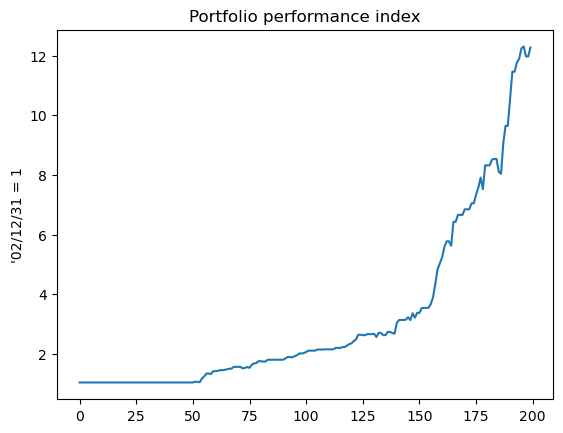

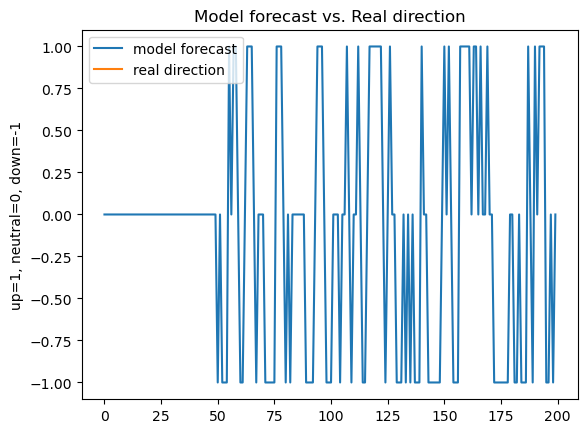

In [16]:

# 4. 전략 수익률 생성
# 전월말 투자의견이 상승이면 코스피 long, 보합이면 Cash, 하락이면 코스피 Short 실행. 
# 해당 전략에 따라 포트 월별수익률(port_return) 생성
kdata.loc[kdata['pre_stage']=='up', 'port_return'] = kdata['m_return']*1 
kdata.loc[kdata['pre_stage'].isna(), 'port_return'] = kdata['m_return']*1 
kdata.loc[kdata['pre_stage']=='neutral', 'port_return'] = 0 
kdata.loc[kdata['pre_stage']=='down', 'port_return'] = kdata['m_return']*-1 
# 코스피와 모델포트폴리오의 누적수익률(1에서 시작하는 인덱스 형태) 생성
kdata['kospi_cumul']=(1+kdata['m_return']).cumprod() 
kdata['port_cumul']=(1+kdata['port_return']).cumprod() 
# 5. 백테스팅 결과 기록(CAGR, 변동성, Sharpe ratio, MDD) 
my_back = {'months':len(kdata)} 

my_back['k_cumul_return_idx'] = kdata['kospi_cumul'].iloc[-1]
my_back['k_cumul_return_pct']=(my_back['k_cumul_return_idx']-1)*100 
my_back['k_cagr']=(my_back['k_cumul_return_idx']**(12/my_back['months']))-1 
my_back['k_cagr_pct']=my_back['k_cagr']*100 
my_back['k_vol_pct']=np.std(kdata['m_return'])*np.sqrt(12)*100 
my_back['k_Sharpe']=my_back['k_cagr_pct']/my_back['k_vol_pct'] 
my_back['k_MDD']=MDD(kdata['kospi_cumul'])*100 

my_back['port_cumul_return_idx'] = kdata['port_cumul'].iloc[-1]
my_back['port_cumul_return_pct']=(my_back['port_cumul_return_idx']-1)*100 
my_back['port_cagr']=(my_back['port_cumul_return_idx']**(12/my_back['months']))-1 
my_back['port_cagr_pct']=my_back['port_cagr']*100 
my_back['port_vol_pct']=np.std(kdata['port_return'])*np.sqrt(12)*100 
my_back['port__Sharpe']=my_back['port_cagr_pct']/my_back['port_vol_pct'] 
my_back['port_MDD']=MDD(kdata['port_cumul'])*100 

# 6. 백테스팅 결과 출력하기
print("<Backtesting result>") 
for key, value in my_back.items(): 
 print("{:22}: {:>8.3f}".format(key, value)) 
 
# 포트폴리오 누적수익률 그래프
kdata['port_cumul'].plot() 
plt.title('Portfolio performance index') 
plt.ylabel('\'02/12/31 = 1') 
plt.show() 

# 7. 월말 모델전망치와 실제결과치 출력
# 월말 실제결과치 입력
for index in kdata.index:
    # Use .get method with a default value to avoid KeyError
    kdata.loc[index, 'real_stage'] = y.get(kdata.loc[index, 'before_last'], 'default_value')
# 사후방향성 클래스를 수치로 변환
kdata['stage_num']=convert_num(kdata['stage']) 
kdata['real_stage_num']=convert_num(kdata['real_stage']) 

# 전망치와 결과치의 그래프 출력
kdata.plot(y=['stage_num', 'real_stage_num'], label=['model forecast','real direction']) 
plt.title('Model forecast vs. Real direction') 
plt.ylabel('up=1, neutral=0, down=-1') 
plt.show() 